## Jupyter Notebook for evaluation on test dataset

In [1]:
import pickle5 as pickle
import argparse
import numpy as np
from resnet import Resnet, BasicBlock
import torch
from torchvision import transforms
import pandas as pd
import matplotlib.pyplot as plt
import random

### Loading the dataset and preprocessing

In [2]:
# Filling in the paths
dataset_path = 'data/cifar_test_nolabels.pkl'
model_ckpt = 'checkpoints/best_ckpt_student_distil.pth'

In [3]:
# Reading the test dataset
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

test_dict = unpickle(dataset_path)
test_data, test_ids = test_dict[b'data'], test_dict[b'ids']

# Data transform for test dataset
img_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

### Creating the model and loading the pretrained weights

In [4]:
model = Resnet(BasicBlock, [2,1,1,1], 10)
model = model.cuda()
num_params = np.sum([p.nelement() for p in model.parameters()]) # Printing the number of parameters
print(num_params, ' parameters')

load_ckpt = torch.load(model_ckpt)
model.load_state_dict(load_ckpt['model'])
model.eval()
print("Validation accuracy obtained previously:", load_ckpt['accuracy'])

4977226  parameters
Validation accuracy obtained previously: 92.66


### Performing evaluation on the test images and finding the predictions

In [5]:
# Now we are passing in the test data and noting down the predictions
prediction_data = {'ID':[], 'Labels':[]}
for i in range(len(test_data)):
    img = test_data[i].reshape(3,32,32).transpose(1,2,0)
    img_tensor = img_transform(img).unsqueeze(0).cuda()
    with torch.no_grad():
        outputs = model(img_tensor)
        _, predicted = torch.max(outputs.data, 1)
        prediction_data['Labels'].append(predicted.item())
        prediction_data['ID'].append(test_ids[i])

In [6]:
# Saving the predictions in the csv file
df = pd.DataFrame(data=prediction_data)
df.set_index('ID', inplace=True)
df.to_csv('submission.csv')

### Visualizing some of the predictions along with the respective test images

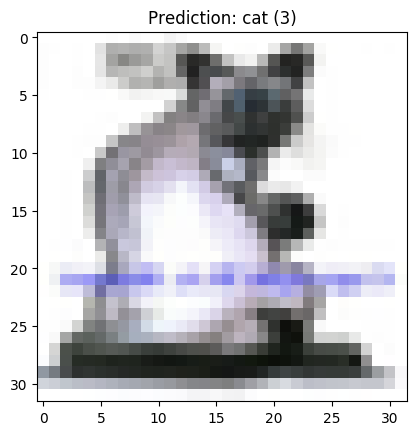

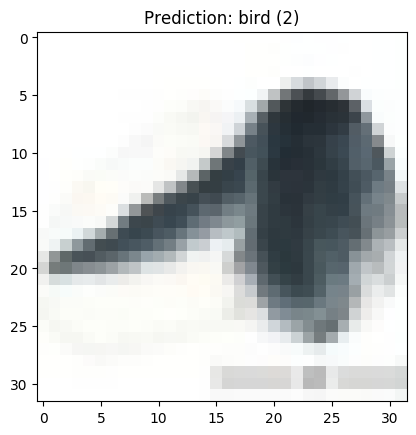

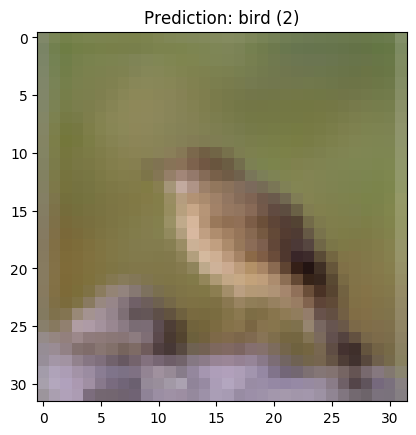

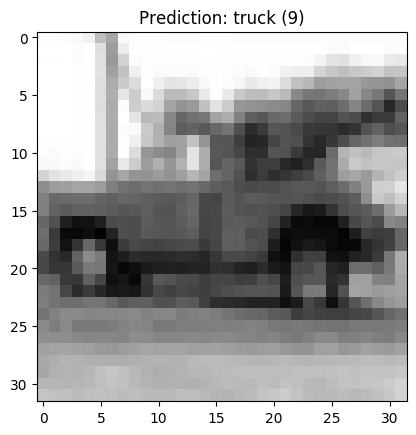

In [7]:
# Plotting some of the test images, along with its predictions
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

for _ in range(4):
    ind = random.choice(range(len(test_data)))
    prediction = prediction_data['Labels'][ind]
    id = prediction_data['ID'][ind]
    img = test_data[ind].reshape(3,32,32).transpose(1,2,0)
    plt.imshow(img)
    plt.title(f"Prediction: {label_names[prediction]} ({prediction})")
    plt.show()